# A Simple Demo of AdaSTEM model using stemflow package

Yangkang Chen<br>
Sep 4, 2023

In [13]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas

# warnings.filterwarnings('ignore')
%matplotlib inline

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
data = pd.read_csv(f'./stemflow/dataset/test_data/Sample_data_Mallard.csv')


# Get X and y

In [16]:
X = data.drop('count', axis=1)
y = data['count'].values


# First thing first: Spatio-temporal train test split

In [19]:
from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                       Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                       random_state=42, test_size=0.3)


# Train AdaSTEM hurdle model

In [20]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


In [21]:
model = Hurdle_for_AdaSTEM(
    classifier=AdaSTEMClassifier(base_model=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True),
    regressor=AdaSTEMRegressor(base_model=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True)
)





In [210]:
model.fit(X_train.reset_index(drop=True), y_train)

training: 100%|██████████| 14646/14646 [08:45<00:00, 27.88it/s] 


# Feature importances

In [211]:
# Calcualte feature importance. This method is automatically called when fitting the model.
# However, to show the process, we call it again.
model.classifier.calculate_feature_importances()
# stixel-specific feature importance is saved in model.classifier.feature_importances_

In [212]:
# Assign the feature importance to spatio-temporal points of interest
importances_by_points = model.classifier.assign_feature_importances_by_points(verbosity=1)

Processing 9 : 100%|██████████| 4757/4757 [01:59<00:00, 39.87it/s]


In [222]:
importances_by_points.head()

DOY  longitude  latitude  longitude_new  latitude_new  DOY_predictor  \
743478  330        167       -52     -82.414173    161.998117       0.012044   
743531  330        168       -52     -83.089988    162.735188       0.012044   
743584  330        169       -52     -83.765803    163.472259       0.012044   
762402  351        164       -51     -81.123799    159.111088       0.011265   
762403  358        164       -51     -81.123799    159.111088       0.013778   

        duration_minutes  Traveling  Stationary  Area  effort_distance_km  \
743478          0.015840   0.010630         0.0   0.0            0.034125   
743531          0.015840   0.010630         0.0   0.0            0.034125   
743584          0.015840   0.010630         0.0   0.0            0.034125   
762402          0.017106   0.004302         0.0   0.0            0.087538   
762403          0.021220   0.000072         0.0   0.0            0.096318   

        number_observers  obsvr_species_count  \
743478          0.009352             0.021255   
743531          0.009352             0.021255   
743584          0.009352             0.021255   
762402          0.009352             0.017173   
762403          0.006516             0.014192   

        time_observation_started_minute_of_day  elevation_mean  slope_mean  \
743478                                0.013561        0.051327    0.044835   
743531                                0.013561        0.051327    0.044835   
743584                                0.013561        0.051327    0.044835   
762402                                0.012866        0.028276    0.028060   
762403                                0.014742        0.027617    0.019841   

        eastness_mean  northness_mean      bio1      bio2      bio3      bio4  \
743478       0.024011        0.030103  0.010248  0.068765  0.015556  0.007125   
743531       0.024011        0.030103  0.010248  0.068765  0.015556  0.007125   
743584       0.024011        0.030103  0.010248  0.068765  0.015556  0.007125   
762402       0.030380        0.013862  0.011905  0.044932  0.032188  0.004732   
762403       0.036942        0.016265  0.021492  0.053694  0.032833  0.000964   

            bio5      bio6      bio7      bio8      bio9     bio10     bio11  \
743478  0.090230  0.050277  0.000361  0.013379  0.019235  0.027804  0.006207   
743531  0.090230  0.050277  0.000361  0.013379  0.019235  0.027804  0.006207   
743584  0.090230  0.050277  0.000361  0.013379  0.019235  0.027804  0.006207   
762402  0.074165  0.060988  0.000361  0.042190  0.018633  0.034690  0.001233   
762403  0.060056  0.039490  0.027871  0.063206  0.019088  0.019819  0.000116   

           bio12     bio13     bio14     bio15     bio16     bio17     bio18  \
743478  0.033999  0.006690  0.035054  0.031882  0.010097  0.003268  0.019865   
743531  0.033999  0.006690  0.035054  0.031882  0.010097  0.003268  0.019865   
743584  0.033999  0.006690  0.035054  0.031882  0.010097  0.003268  0.019865   
762402  0.031538  0.008447  0.038098  0.000000  0.007496  0.002447  0.019316   
762403  0.022801  0.012423  0.038866  0.003227  0.007496  0.005867  0.023278   

           bio19  closed_shrublands  cropland_or_natural_vegetation_mosaics  \
743478  0.000451                0.0                                     0.0   
743531  0.000451                0.0                                     0.0   
743584  0.000451                0.0                                     0.0   
762402  0.044886                0.0                                     0.0   
762403  0.045148                0.0                                     0.0   

        croplands  deciduous_broadleaf_forests  evergreen_broadleaf_forests  \
743478        0.0                          0.0                     0.025065   
743531        0.0                          0.0                     0.025065   
743584        0.0                          0.0                     0.025065   
762402        0.0                          0.0              

In [221]:
# top 10 important variables
top_10_important_vars = importances_by_points[[
    i for i in importances_by_points.columns if not i in ['DOY','longitude','latitude','longitude_new','latitude_new']
    ]].mean().sort_values(ascending=False).head(10)

print(top_10_important_vars)


slope_mean             0.040001
effort_distance_km     0.038782
elevation_mean         0.036989
duration_minutes       0.035386
eastness_mean          0.033536
bio2                   0.030341
northness_mean         0.030057
bio4                   0.030024
obsvr_species_count    0.029609
bio1                   0.029572
dtype: float64


## Ploting the feature importances by vairable names

In [227]:
from stemflow.utils.plot_gif import make_sample_gif

# make spatio-temporal GIF for top 3 variables
for var_ in top_10_important_vars.index[:3]:
    make_sample_gif(importances_by_points, f'./test_output/FTR_IPT_{var_}.gif',
                                col=var_, log_scale = False,
                                Spatio1='longitude', Spatio2='latitude', Temporal1='DOY',
                                figsize=(18,9), xlims=(-180, 180), ylims=(-90,90), grid=True,
                                xtick_interval=20, ytick_interval=20,
                                lng_size = 360, lat_size = 180, dpi=100, fps=10)


0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!


![GIF of feature importance for vairable `slope_mean`](../FTR_IPT_slope_mean.gif)

## Plot uncertainty (error) in training 

In [228]:
# calculate mean and standard deviation in occurence estiamtion (classifier)
pred_mean, pred_std = model.classifier.predict(X_train.reset_index(drop=True), return_std=True)


In [229]:
# Aggregate error to hexagon
error_df = X_train[['longitude', 'latitude']]
error_df.columns = ['lng', 'lat']
error_df['pred_std'] = pred_std

H_level = 3
error_df = error_df.h3.geo_to_h3(H_level)
error_df = error_df.reset_index(drop=False).groupby(f'h3_0{H_level}').mean()
error_df = error_df.h3.h3_to_geo_boundary()


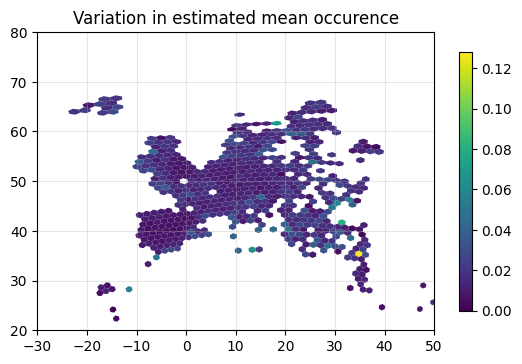

In [230]:
# plot mean error in hexagon
error_df.plot('pred_std', legend=True, legend_kwds={'shrink':0.7})
plt.grid(alpha=0.3)
plt.xlim(-30, 50)
plt.ylim(20, 80)
plt.title('Variation in estimated mean occurence')
plt.show()

# Save model

In [ ]:
with open('./test_output/01.demo_adastem_model.pkl','wb') as f:
    pickle.dump(model, f)
    

# Evaluation

In [233]:
pred = model.predict(X_test)


In [234]:
perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
print(f'Percentage not predictable {round(perc*100, 2)}%')

Percentage not predictable 5.17%


In [235]:
pred_df = pd.DataFrame({
    'y_true':y_test.flatten(),
    'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
}).dropna()


In [236]:
AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)


{'AUC': 0.6829616464245183,
 'kappa': 0.41664676741031326,
 'f1': 0.4965879601448115,
 'precision': 0.6053268765133172,
 'recall': 0.420966865833786,
 'average_precision': 0.3515469931799888,
 'Spearman_r': 0.4363925902980102,
 'Pearson_r': 0.199554260228199,
 'R2': -0.060943185212448014,
 'MAE': 4.119575450532007,
 'MSE': 1356.1821854384439,
 'poisson_deviance_explained': 0.1699717723244235}

# Compared to simple Hurdle model

In [237]:
model2 = Hurdle(classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1))
model2.fit(X_train[[i for i in X_train.columns if not i in ['longitude','latitude']]], y_train)
pred2 = model2.predict(X_test[[i for i in X_train.columns if not i in ['longitude','latitude']]])

AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), np.where(pred2.flatten()<0, 0, pred2.flatten()))

{'AUC': 0.614874754867373,
 'kappa': 0.3024531192247014,
 'f1': 0.3682267387656163,
 'precision': 0.643005991143527,
 'recall': 0.25798191984114544,
 'average_precision': 0.288061783500689,
 'Spearman_r': 0.3520394407206567,
 'Pearson_r': 0.15540117044791554,
 'R2': -0.11859108757092018,
 'MAE': 3.99918310458487,
 'MSE': 1405.505184365956,
 'poisson_deviance_explained': 0.06904965429918242}

# Plot QuadTree ensembles

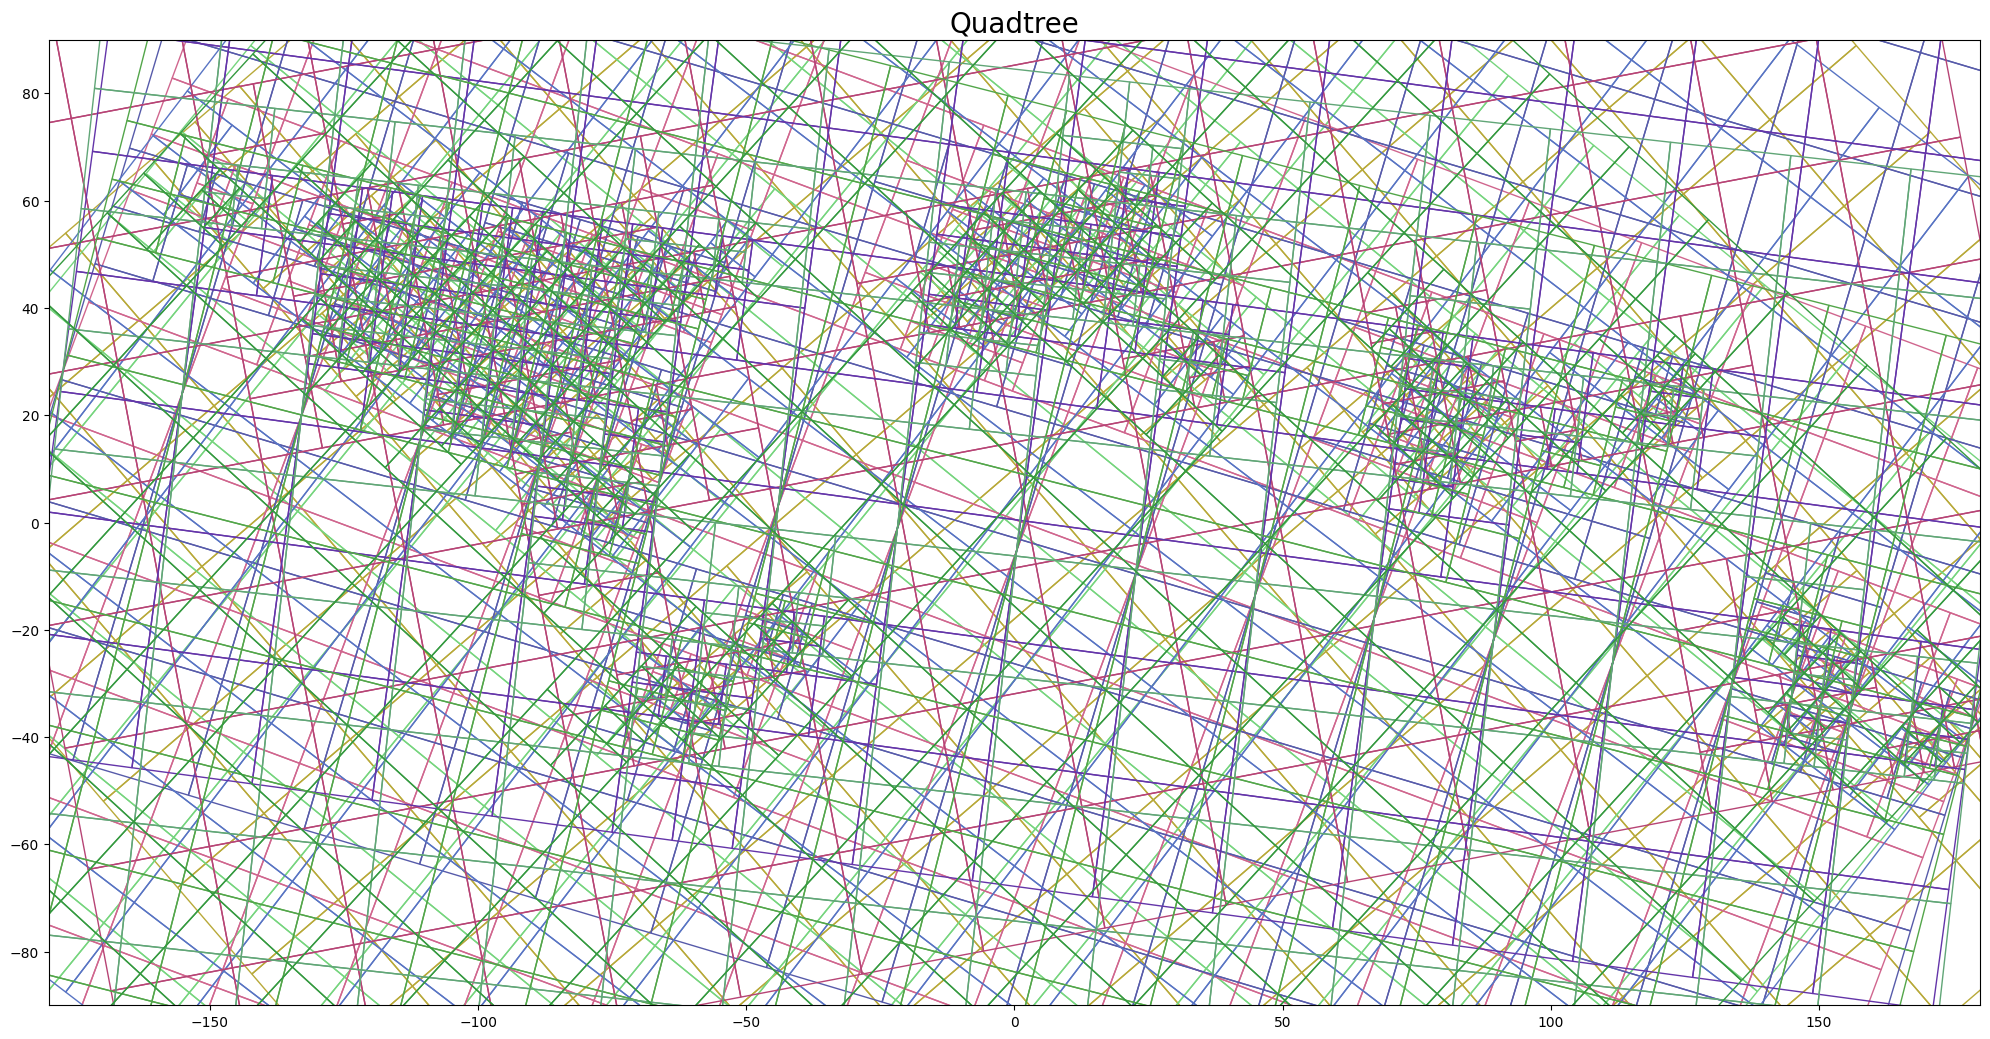

In [238]:
model.classifier.gridding_plot

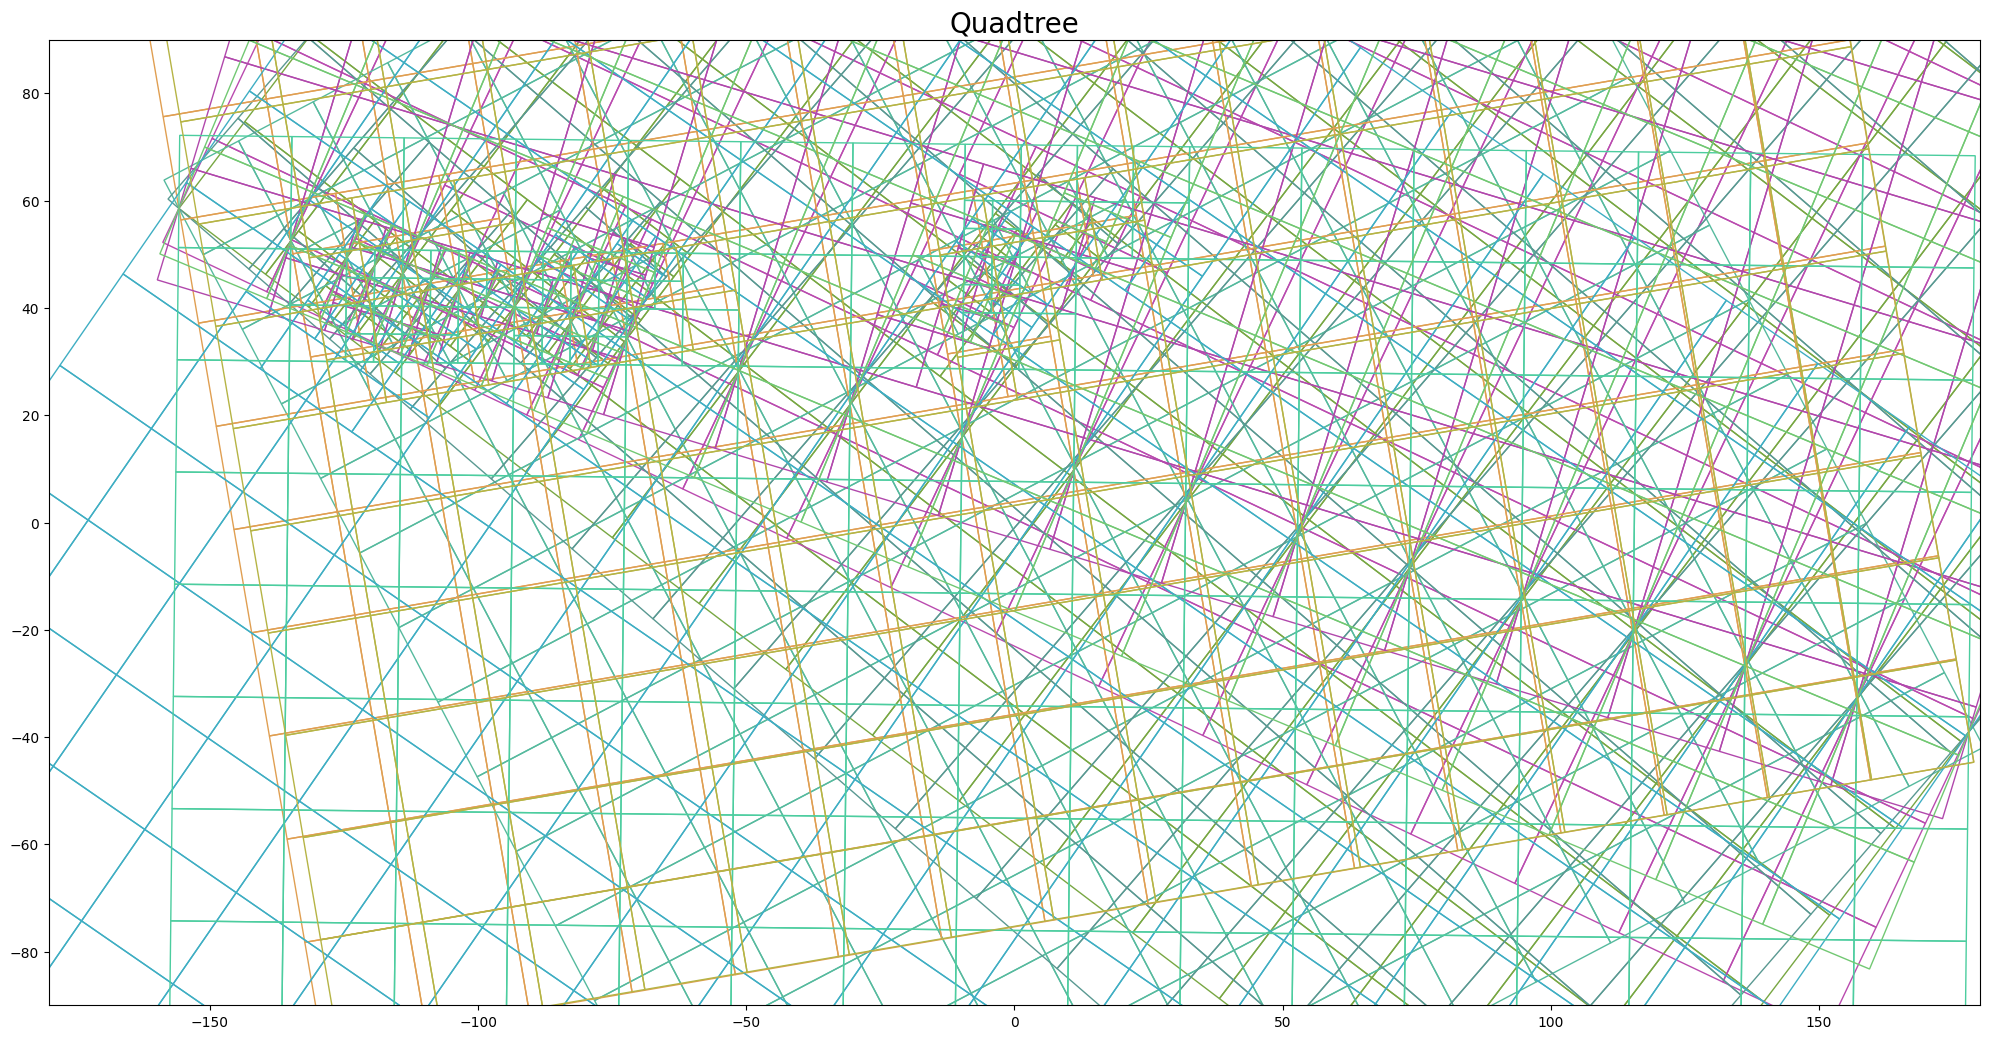

In [239]:
model.regressor.gridding_plot

In [56]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Sep 06 2023

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

geopandas : 0.11.1
numpy     : 1.24.3
matplotlib: 3.7.1
pandas    : 2.0.3

Watermark: 2.3.1

